In [79]:
import os
import sys
import csv
import textwrap
import warnings

sys.path.append(os.path.dirname(os.getcwd()))

import matplotlib.pyplot as plt
import numpy as np

from adjustText import adjust_text

from utils.checkpoint import load_params

from model.train.recommender import optimize_users

warnings.simplefilter("ignore")

#### Load Embeddings

In [80]:
params = load_params("../artifacts/model/32m_users_training_features_2.npz")
feat_embeddings_2d = params["feat_embedding"]
idx_to_feat_id = params['idx_to_feat_id']

In [81]:
params = load_params("../artifacts/model/32m_users_training_2.npz")
movie_embeddings_2d = params["movie_embedding"]

In [82]:
params = load_params("../artifacts/model/32m_users_training_10.npz")
r_lambda = params["r_lambda"]
r_tau = params["r_tau"]
r_gamma = params["r_gamma"]
idx_to_user_id = params["idx_to_user_id"]
idx_to_movie_id = params["idx_to_movie_id"]
user_bias = params["user_bias"]
movie_bias = params["movie_bias"]
user_embeddings = params["user_embedding"]
movie_embeddings = params["movie_embedding"]

In [83]:
params = load_params("../artifacts/model/32m_users_training_features_10.npz")
user_bias_with_f = params["user_bias"]
movie_bias_with_f = params["movie_bias"]
user_embeddings_with_f = params["user_embedding"]
movie_embeddings_with_f = params["movie_embedding"]

#### Load Data

In [84]:
user_id_to_idx = {v:k for k, v in enumerate(idx_to_user_id)}
movie_id_to_idx = {v:k for k, v in enumerate(idx_to_movie_id)}

user_movie = [([],[]) for _ in range(len(idx_to_user_id))]
movie_user = [([],[]) for _ in range(len(idx_to_movie_id))]

with open("../data/ml-32m/ratings.csv") as f:
    reader = csv.reader(f)
    _ = next(reader)
    for row in reader:
        user_id, movie_id, rating, _ = row
        user_idx = user_id_to_idx[user_id]
        movie_idx = movie_id_to_idx[movie_id]
        user_movie[user_idx][0].append(movie_idx)
        user_movie[user_idx][1].append(float(rating))
        movie_user[movie_idx][0].append(user_idx)
        movie_user[movie_idx][1].append(float(rating))

movie_id_to_title = {}
title_to_movie_id = {}
movie_id_to_genres = {}

with open("../data/ml-32m/movies.csv") as f:
    reader = csv.reader(f)
    _ = next(reader)
    for row in reader:
        movie_id, title, genres = row
        movie_id_to_title[movie_id] = title
        title_to_movie_id[title] = movie_id
        movie_id_to_genres[movie_id] = genres

#### Movie Embedding Space

In [85]:
idx_to_title = {v: movie_id_to_title[k] for k, v in movie_id_to_idx.items()}

In [86]:
movie_choice = list(
    filter(
        lambda x: (
            ("lord of the rings" in idx_to_title[x].lower())
            or ("fifty shades" in idx_to_title[x].lower())
            or ("despicable me" in idx_to_title[x].lower())
            or ("hotel transylvania" in idx_to_title[x].lower())
        ),
        range(len(movie_user))
    )
)

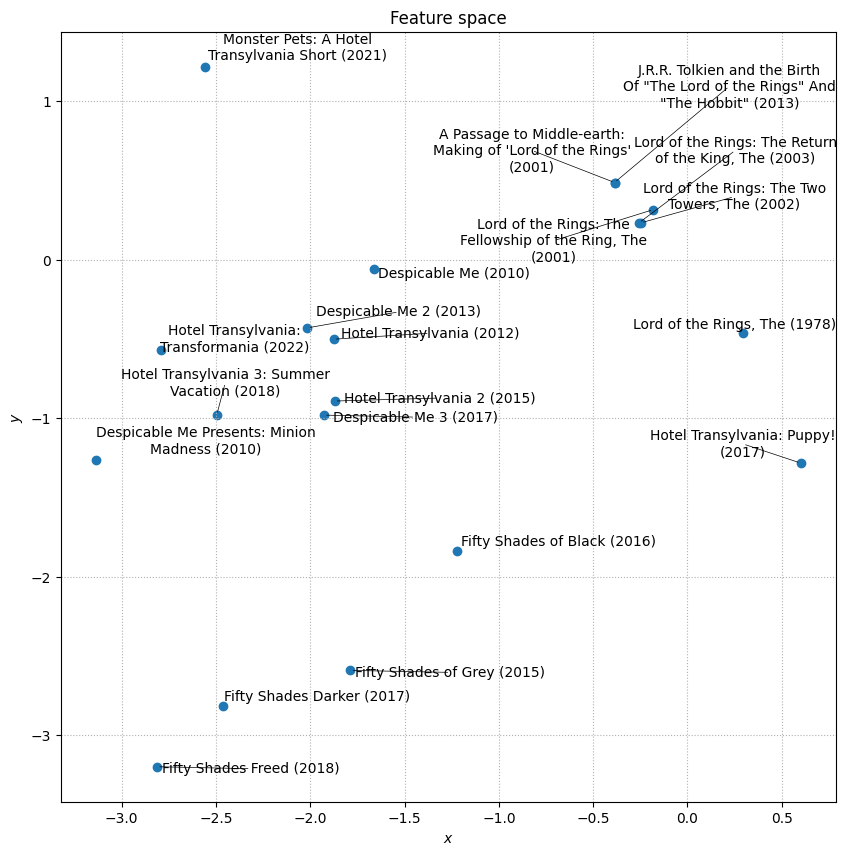

In [87]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_choice, 0], movie_embeddings_2d[movie_choice, 1])

texts = []
for i in movie_choice:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Feature space")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/32m_movie_embedd_space.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Feature Embedding Space

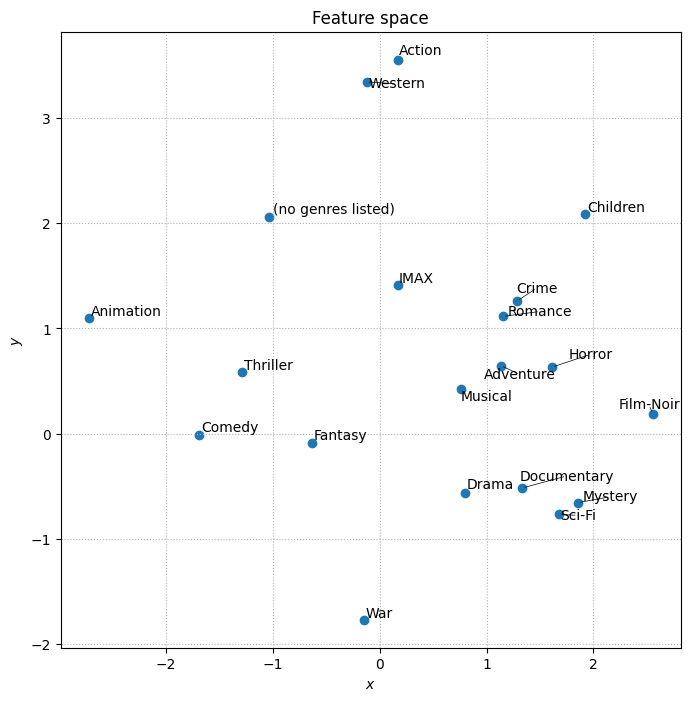

In [88]:
plt.subplots(figsize=(8, 8))

plt.scatter(feat_embeddings_2d[:,0], feat_embeddings_2d[:,1])

texts = []
for i, x in enumerate(feat_embeddings_2d):
    texts.append(plt.annotate(idx_to_feat_id[i], x))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Feature space")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/32m_feature_2_space.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Dummy User Embedding

In [89]:
lord_of_the_ring_title = "Lord of the Rings: The Fellowship of the Ring, The (2001)"
lord_of_the_ring_id = title_to_movie_id[lord_of_the_ring_title]
lord_of_the_ring_rating = 5.0
lord_of_the_ring_idx = movie_id_to_idx[lord_of_the_ring_id]

print(f"Movie: {lord_of_the_ring_title}")
print(f"Degree: {len(movie_user[lord_of_the_ring_idx][0])}")
print(f"Genres: {movie_id_to_genres[lord_of_the_ring_id]}")

Movie: Lord of the Rings: The Fellowship of the Ring, The (2001)
Degree: 73122
Genres: Adventure|Fantasy


In [90]:
dummy_id = "dummy"
dummy_idx = len(user_id_to_idx)
user_id_to_idx[dummy_id] = dummy_idx
idx_to_user_id.append(dummy_id)

user_movie.append((
    [lord_of_the_ring_idx], [lord_of_the_ring_rating]
))

movie_user[lord_of_the_ring_idx][0].append(dummy_idx)
movie_user[lord_of_the_ring_idx][1].append(lord_of_the_ring_rating)

user_embeddings = np.vstack([user_embeddings, np.random.normal(0, np.sqrt(user_embeddings.shape[1]), (user_embeddings.shape[1]))])
user_bias = np.hstack([user_bias, np.random.randn()])

user_embeddings_with_f = np.vstack([user_embeddings_with_f, np.random.normal(0, np.sqrt(user_embeddings_with_f.shape[1]), (user_embeddings_with_f.shape[1]))])
user_bias_with_f = np.hstack([user_bias_with_f, np.random.randn()])

assert len(user_embeddings) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"
assert len(user_bias) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"
assert len(user_embeddings_with_f) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"
assert len(user_bias_with_f) == len(user_id_to_idx) == len(user_movie), "Inconsistency in user data"

In [91]:
for i in range(len(user_movie)):
    user_movie[i] = (
        np.array(user_movie[i][0], dtype=int),
        np.array(user_movie[i][1], dtype=np.float64),
    )

for i in range(len(movie_user)):
    movie_user[i] = (
        np.array(movie_user[i][0], dtype=int),
        np.array(movie_user[i][1], dtype=np.float64),
    )

In [92]:
old_embedding = user_embeddings[dummy_idx].copy()

for _ in range(5):
    optimize_users(
        [user_movie[dummy_idx]],
        user_embeddings.shape[1],
        r_lambda,
        r_gamma,
        r_tau,
        user_bias,
        movie_bias,
        user_embeddings[dummy_idx, np.newaxis],
        movie_embeddings
    )

assert ((old_embedding - user_embeddings[dummy_idx]) > 1e-2).any(), "Embedding not updated"

In [93]:
old_embedding = user_embeddings_with_f[dummy_idx].copy()

for _ in range(5):
    optimize_users(
        [user_movie[dummy_idx]],
        user_embeddings_with_f.shape[1],
        r_lambda,
        r_gamma,
        r_tau,
        user_bias_with_f,
        movie_bias_with_f,
        user_embeddings_with_f[dummy_idx, np.newaxis],
        movie_embeddings_with_f
    )

assert ((old_embedding - user_embeddings_with_f[dummy_idx]) > 1e-2).any(), "Embedding not updated"

#### Top 10 Prediction for Dummy User

In [94]:
movie_scores = movie_embeddings @ user_embeddings[dummy_idx] + movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])

Top 10 Prediction
1 - Modern Musketeer, A (1917)  - degree: 1  - genres: Adventure|Comedy|Western
2 - Happy Birthday (2016)  - degree: 1  - genres: Horror|Thriller
3 - Fertile Ground (2011)  - degree: 1  - genres: Horror
4 - Moomintroll and the Comet (1978)  - degree: 2  - genres: Animation|Children
5 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449  - genres: Action|Adventure|Drama|Fantasy
6 - Go Ahead, Brazil! (1982)  - degree: 1  - genres: Crime|Drama
7 - Hobbit: The Desolation of Smaug, The (2013)  - degree: 12175  - genres: Adventure|Fantasy|IMAX
8 - The Hobbit: The Battle of the Five Armies (2014)  - degree: 8616  - genres: Adventure|Fantasy
9 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463  - genres: Adventure|Fantasy
10 - Lord of the Rings: The Fellowship of the Ring, The (2001)  - degree: 73123  - genres: Adventure|Fantasy


In [95]:
movie_scores = movie_embeddings @ user_embeddings[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias]")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])

Top 10 Prediction [downplayed bias]
1 - Expelled: No Intelligence Allowed (2008)  - degree: 166  - genres: Documentary
2 - The Hobbit: The Battle of the Five Armies (2014)  - degree: 8616  - genres: Adventure|Fantasy
3 - Moomintroll and the Comet (1978)  - degree: 2  - genres: Animation|Children
4 - Hobbit: The Desolation of Smaug, The (2013)  - degree: 12175  - genres: Adventure|Fantasy|IMAX
5 - Hobbit: An Unexpected Journey, The (2012)  - degree: 16149  - genres: Adventure|Fantasy|IMAX
6 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449  - genres: Action|Adventure|Drama|Fantasy
7 - Go Ahead, Brazil! (1982)  - degree: 1  - genres: Crime|Drama
8 - The Curious Birth of Benjamin Button (2009)  - degree: 32  - genres: Documentary
9 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463  - genres: Adventure|Fantasy
10 - Curse of the Ring (Ring of the Nibelungs) (2004)  - degree: 31  - genres: Action|Adventure|Drama|Fantasy


In [96]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 100
])

movie_scores = movie_embeddings @ user_embeddings[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias + rating filtering (>100 rating only)]")

i = 0
for idx in reversed(dummy_movie_ranks):
    if i == 10:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])
    i += 1

Top 10 Prediction [downplayed bias + rating filtering (>100 rating only)]
1 - Expelled: No Intelligence Allowed (2008)  - degree: 166  - genres: Documentary
2 - The Hobbit: The Battle of the Five Armies (2014)  - degree: 8616  - genres: Adventure|Fantasy
3 - Hobbit: The Desolation of Smaug, The (2013)  - degree: 12175  - genres: Adventure|Fantasy|IMAX
4 - Hobbit: An Unexpected Journey, The (2012)  - degree: 16149  - genres: Adventure|Fantasy|IMAX
5 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449  - genres: Action|Adventure|Drama|Fantasy
6 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463  - genres: Adventure|Fantasy
7 - Lord of the Rings: The Fellowship of the Ring, The (2001)  - degree: 73123  - genres: Adventure|Fantasy
8 - Batman v Superman: Dawn of Justice (2016)  - degree: 4547  - genres: Action|Adventure|Fantasy|Sci-Fi
9 - Star Wars: Episode III - Revenge of the Sith (2005)  - degree: 24773  - genres: Action|Adventure|Sci-Fi
10 - Star Wars:

#### Top 10 Prediction for Dummy User [with features]

In [97]:
movie_scores = movie_embeddings_with_f @ user_embeddings_with_f[dummy_idx] + movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])

Top 10 Prediction
1 - Pokémon the Movie: Hoopa and the Clash of Ages (2015)  - degree: 23  - genres: Action|Adventure|Animation
2 - Ουζερί Τσιτσάνης  - degree: 11  - genres: (no genres listed)
3 - Ouija Seance: The Final Game (2018)  - degree: 1  - genres: Horror
4 - Past Death (2020)  - degree: 1  - genres: Thriller
5 - IMAX - The Dream Is Alive (1985)  - degree: 3  - genres: Documentary
6 - CzechMate: In Search of Jiří Menzel (2018)  - degree: 1  - genres: Documentary
7 - Nurnberg (2023)  - degree: 1  - genres: Drama
8 - Attack on Titan: Chronicle (2020)  - degree: 26  - genres: Action|Adventure|Animation|Fantasy
9 - The Four Horsemen (2008)  - degree: 1  - genres: Action|Drama|War
10 - Awakening (2008)  - degree: 5  - genres: (no genres listed)


In [98]:
movie_scores = movie_embeddings_with_f @ user_embeddings_with_f[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias]")

for i, idx in enumerate(reversed(dummy_movie_ranks[-10:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])

Top 10 Prediction [downplayed bias]
1 - Pokémon the Movie: Hoopa and the Clash of Ages (2015)  - degree: 23  - genres: Action|Adventure|Animation
2 - Ουζερί Τσιτσάνης  - degree: 11  - genres: (no genres listed)
3 - The Asylum (2016)  - degree: 12  - genres: Action|Horror|Mystery|Sci-Fi|Thriller
4 - Awakening (2008)  - degree: 5  - genres: (no genres listed)
5 - Anacronte (2019)  - degree: 2  - genres: (no genres listed)
6 - CzechMate: In Search of Jiří Menzel (2018)  - degree: 1  - genres: Documentary
7 - Appleseed: Ex Machina (2007)  - degree: 51  - genres: Action|Animation|Sci-Fi|Thriller
8 - Past Death (2020)  - degree: 1  - genres: Thriller
9 - Attack on Titan: Chronicle (2020)  - degree: 26  - genres: Action|Adventure|Animation|Fantasy
10 - The last summit (2010)  - degree: 1  - genres: Documentary


In [99]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 100
])

movie_scores = movie_embeddings_with_f @ user_embeddings_with_f[dummy_idx] + 0.05 * movie_bias

dummy_movie_ranks = np.argsort(movie_scores)

print("Top 10 Prediction [downplayed bias + rating filtering (>100 rating only)]")

i = 0
for idx in reversed(dummy_movie_ranks):
    if i == 10:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]), " - genres:", movie_id_to_genres[pred_id])
    i += 1

Top 10 Prediction [downplayed bias + rating filtering (>100 rating only)]
1 - Hobbit: The Desolation of Smaug, The (2013)  - degree: 12175  - genres: Adventure|Fantasy|IMAX
2 - The Hobbit: The Battle of the Five Armies (2014)  - degree: 8616  - genres: Adventure|Fantasy
3 - Batman v Superman: Dawn of Justice (2016)  - degree: 4547  - genres: Action|Adventure|Fantasy|Sci-Fi
4 - Lord of the Rings: The Return of the King, The (2003)  - degree: 67449  - genres: Action|Adventure|Drama|Fantasy
5 - Avengers: Age of Ultron (2015)  - degree: 12099  - genres: Action|Adventure|Sci-Fi
6 - Star Wars: The Last Jedi (2017)  - degree: 6646  - genres: Action|Adventure|Fantasy|Sci-Fi
7 - Hobbit: An Unexpected Journey, The (2012)  - degree: 16149  - genres: Adventure|Fantasy|IMAX
8 - Lord of the Rings: The Two Towers, The (2002)  - degree: 67463  - genres: Adventure|Fantasy
9 - Avengers: Infinity War - Part II (2019)  - degree: 11811  - genres: Action|Adventure|Sci-Fi
10 - Lord of the Rings: The Fellowsh

#### Top Polarizing Movies

In [100]:
movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Top 20 Movie by embedding norm")

for i, idx in enumerate(reversed(movie_embedding_norm[-20:])):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))

Top 20 Movie by embedding norm
1 - Fateful Findings (2013)  - degree: 79
2 - Twisted Pair (2018)  - degree: 31
3 - Begum Jaan (2017)  - degree: 2
4 - Он вам не Димон (2017)  - degree: 58
5 - Man Who Saves the World, The (Dünyayi Kurtaran Adam) (1982)  - degree: 67
6 - Summer Place Wanted (1957)  - degree: 1
7 - Jecão... Um Fofoqueiro no Céu (1977)  - degree: 1
8 - Prem Ratan Dhan Payo (2015)  - degree: 25
9 - Nude Nuns with Big Guns (2010)  - degree: 47
10 - Space Cop (2016)  - degree: 41
11 - Kevin Smith: Sold Out - A Threevening with Kevin Smith (2008)  - degree: 42
12 - The Girl in Room 2A (1974)  - degree: 1
13 - Kindar the Invulnerable (1965)  - degree: 1
14 - Hillary's America: The Secret History Of The Democratic Party (2016)  - degree: 29
15 - Brexit: The Movie (2016)  - degree: 15
16 - Love on a Leash (2011)  - degree: 17
17 - Seemaraja (2018)  - degree: 1
18 - Poultrygeist: Night of the Chicken Dead (2006)  - degree: 130
19 - Samurai Cop (1989)  - degree: 107
20 - KonoSuba: G

In [101]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 100
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Top 20 Movie by embedding norm [< 100 rating filtering]")

i = 0
for idx in reversed(movie_embedding_norm):
    if i == 20:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
    i += 1

Top 20 Movie by embedding norm [< 100 rating filtering]
1 - Poultrygeist: Night of the Chicken Dead (2006)  - degree: 130
2 - Samurai Cop (1989)  - degree: 107
3 - Faces of Death 3 (1985)  - degree: 201
4 - Faces of Death 4 (1990)  - degree: 177
5 - Expelled: No Intelligence Allowed (2008)  - degree: 166
6 - Manos: The Hands of Fate (1966)  - degree: 153
7 - Faces of Death 5 (1996)  - degree: 153
8 - Faces of Death 2 (1981)  - degree: 209
9 - The Kissing Booth 2 (2020)  - degree: 151
10 - Begotten (1990)  - degree: 142
11 - Prospero's Books (1991)  - degree: 106
12 - Clifford (1994)  - degree: 166
13 - Faces of Death 6 (1996)  - degree: 172
14 - Twilight Saga: Breaking Dawn - Part 1, The (2011)  - degree: 2703
15 - Satan's Tango (Sátántangó) (1994)  - degree: 182
16 - Twilight Saga: Breaking Dawn - Part 2, The (2012)  - degree: 2362
17 - Look Both Ways (2005)  - degree: 104
18 - Christmas Tale, A (Un conte de Noël) (2008)  - degree: 118
19 - Twilight Saga: Eclipse, The (2010)  - degree

In [102]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 100
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

movie_bag = []

print("Top 20 Movie by embedding norm [cosine similarity filtering + < 100 rating filtering]")

i = 0
for idx in reversed(movie_embedding_norm):
    if i == 20:
        break  
    if idx in filtering:
        continue
        
    inner_prod = np.sum(movie_embeddings[movie_bag] * movie_embeddings[idx], axis=1)
    norm_movie_at_idx = np.linalg.norm(movie_embeddings[idx])
    norm_movie_in_bag = np.linalg.norm(movie_embeddings[movie_bag], axis=1)
    
    if (len(movie_bag) == 0) or (
        ((inner_prod/(norm_movie_in_bag * norm_movie_at_idx)) < 0.9).all()
    ):  
        pred_id = idx_to_movie_id[idx.item()]
        pred_title = movie_id_to_title[pred_id]
        print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
        i += 1
        movie_bag.append(idx)

Top 20 Movie by embedding norm [cosine similarity filtering + < 100 rating filtering]
1 - Poultrygeist: Night of the Chicken Dead (2006)  - degree: 130
2 - Samurai Cop (1989)  - degree: 107
3 - Faces of Death 3 (1985)  - degree: 201
4 - Expelled: No Intelligence Allowed (2008)  - degree: 166
5 - Manos: The Hands of Fate (1966)  - degree: 153
6 - The Kissing Booth 2 (2020)  - degree: 151
7 - Begotten (1990)  - degree: 142
8 - Prospero's Books (1991)  - degree: 106
9 - Clifford (1994)  - degree: 166
10 - Twilight Saga: Breaking Dawn - Part 1, The (2011)  - degree: 2703
11 - Satan's Tango (Sátántangó) (1994)  - degree: 182
12 - Look Both Ways (2005)  - degree: 104
13 - Christmas Tale, A (Un conte de Noël) (2008)  - degree: 118
14 - Grateful Dead (1995)  - degree: 190
15 - The Emoji Movie (2017)  - degree: 314
16 - Barenaked in America (1999)  - degree: 127
17 - Movie 43 (2013)  - degree: 844
18 - The Last Five Years (2014)  - degree: 126
19 - Hera Pheri (2000)  - degree: 142
20 - Room, Th

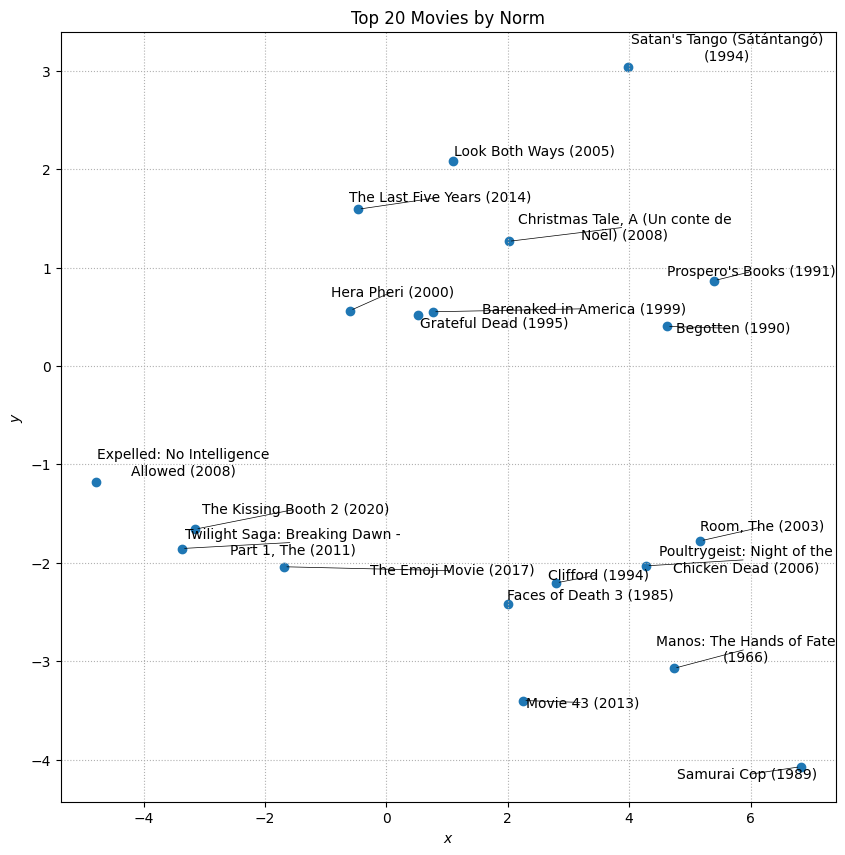

In [103]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_bag, 0], movie_embeddings_2d[movie_bag, 1])

texts = []
for i in movie_bag:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Top 20 Movies by Norm")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/top_polarizing_movie.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Less Polarizing Movies

In [104]:
movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Bottom 20 Movie by embedding norm")

for i, idx in enumerate(movie_embedding_norm[:20]):
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))

Bottom 20 Movie by embedding norm
1 - Guilty Pleasures (2010)  - degree: 1
2 - Another World (2018)  - degree: 1
3 - Tori and Lokita (2022)  - degree: 3
4 - The Arrival (2017)  - degree: 1
5 - Whenever You're Ready (2018)  - degree: 1
6 - Cul-De-Sac (2016)  - degree: 1
7 - The Clark Sisters: First Ladies of Gospel (2020)  - degree: 2
8 - My Broken Mariko (2022)  - degree: 1
9 - Four Sisters (1985)  - degree: 1
10 - Vaa Arugil Vaa (1991)  - degree: 1
11 - Operation Java (2021)  - degree: 1
12 - Cold Case (2021)  - degree: 1
13 - Sri Raghavendra (1985)  - degree: 1
14 - Ayya (2005)  - degree: 1
15 - Salim (2014)  - degree: 1
16 - Thambikku Entha Ooru (1984)  - degree: 1
17 - Samsaram Athu Minsaram (1986)  - degree: 1
18 - Rajaraja Cholan (1973)  - degree: 1
19 - Kadhalikka Neramillai (1964)  - degree: 1
20 - Tik Tik Tik (1981)  - degree: 1


In [105]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 100
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

print("Bottom 20 Movie by embedding norm [< 100 rating filtering]")

i = 0
for idx in movie_embedding_norm:
    if i == 20:
        break
    if idx in filtering:
        continue
    pred_id = idx_to_movie_id[idx.item()]
    pred_title = movie_id_to_title[pred_id]
    print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
    i += 1

Bottom 20 Movie by embedding norm [< 100 rating filtering]
1 - Let's Make Love (1960)  - degree: 105
2 - Prince and the Showgirl, The (1957)  - degree: 106
3 - Sharky's Machine (1981)  - degree: 174
4 - My Name Is Bruce (2007)  - degree: 270
5 - Theatre of Blood (1973)  - degree: 187
6 - Bear, The (Ours, L') (1988)  - degree: 1103
7 - The Waiting (2016)  - degree: 120
8 - Freakonomics (2010)  - degree: 226
9 - Extra Ordinary. (2019)  - degree: 122
10 - Clearing, The (2004)  - degree: 292
11 - Nun's Story, The (1959)  - degree: 106
12 - Vatel (2000)  - degree: 222
13 - Little Nikita (1988)  - degree: 194
14 - Tower (2016)  - degree: 152
15 - Queen of Versailles, The (2012)  - degree: 388
16 - Mr. Saturday Night (1992)  - degree: 729
17 - The Absent One (2014)  - degree: 110
18 - Swing Shift (1984)  - degree: 148
19 - Easy Money (Snabba Cash) (2010)  - degree: 117
20 - Lonely Place to Die, A (2011)  - degree: 143


In [106]:
filtering = set([
    idx for idx in range(len(movie_user)) if len(movie_user[idx][0]) < 100
])

movie_embedding_norm = np.argsort(np.sum(movie_embeddings * movie_embeddings, axis=1))

movie_bag = []

print("Bottom 20 Movie by embedding norm [cosine similarity filtering + <100 ratings filtering]")

i = 0
for idx in movie_embedding_norm:
    if i == 20:
        break 
    if idx in filtering:
        continue

    inner_prod = np.sum(movie_embeddings[movie_bag] * movie_embeddings[idx], axis=1)
    norm_movie_at_idx = np.linalg.norm(movie_embeddings[idx])
    norm_movie_in_bag = np.linalg.norm(movie_embeddings[movie_bag], axis=1)
    
    if (len(movie_bag) == 0) or (
        ((inner_prod/(norm_movie_in_bag * norm_movie_at_idx)) < 0.9).all()
    ):  
        pred_id = idx_to_movie_id[idx.item()]
        pred_title = movie_id_to_title[pred_id]
        print(i+1, "-", pred_title, " - degree:", len(movie_user[idx.item()][0]))
        i += 1
        movie_bag.append(idx)

Bottom 20 Movie by embedding norm [cosine similarity filtering + <100 ratings filtering]
1 - Let's Make Love (1960)  - degree: 105
2 - Prince and the Showgirl, The (1957)  - degree: 106
3 - Sharky's Machine (1981)  - degree: 174
4 - My Name Is Bruce (2007)  - degree: 270
5 - Theatre of Blood (1973)  - degree: 187
6 - Bear, The (Ours, L') (1988)  - degree: 1103
7 - The Waiting (2016)  - degree: 120
8 - Freakonomics (2010)  - degree: 226
9 - Extra Ordinary. (2019)  - degree: 122
10 - Clearing, The (2004)  - degree: 292
11 - Nun's Story, The (1959)  - degree: 106
12 - Vatel (2000)  - degree: 222
13 - Little Nikita (1988)  - degree: 194
14 - Tower (2016)  - degree: 152
15 - Queen of Versailles, The (2012)  - degree: 388
16 - Mr. Saturday Night (1992)  - degree: 729
17 - The Absent One (2014)  - degree: 110
18 - Swing Shift (1984)  - degree: 148
19 - Easy Money (Snabba Cash) (2010)  - degree: 117
20 - Lonely Place to Die, A (2011)  - degree: 143


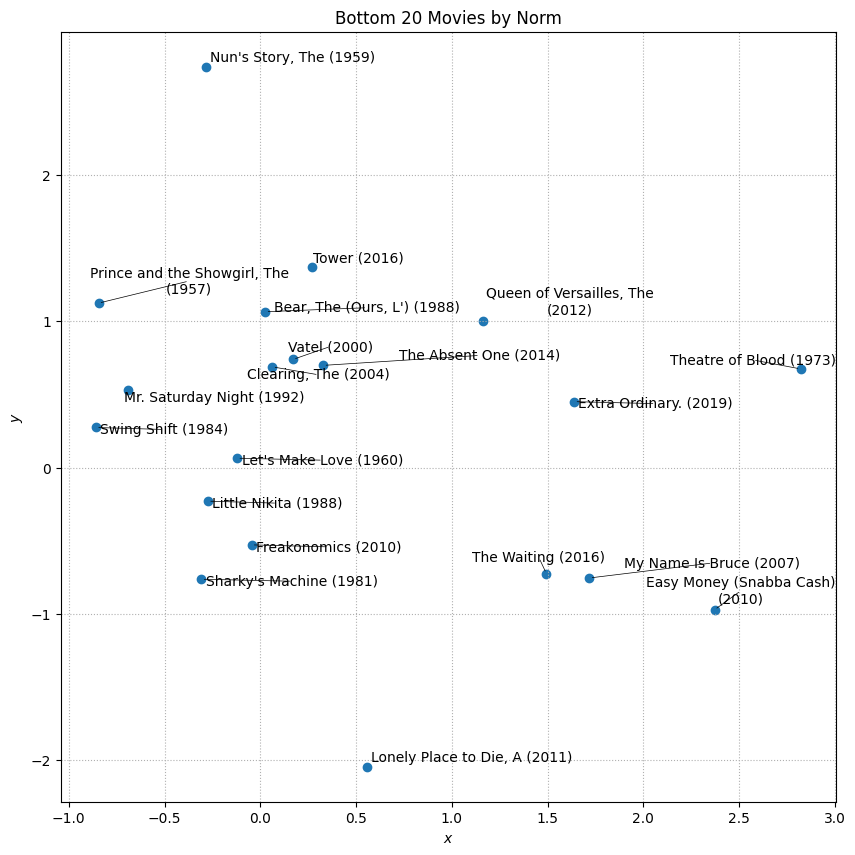

In [107]:
plt.subplots(figsize=(10, 10))

plt.scatter(movie_embeddings_2d[movie_bag, 0], movie_embeddings_2d[movie_bag, 1])

texts = []
for i in movie_bag:
    wrapped_title = "\n".join(textwrap.wrap(idx_to_title[i], width=30))
    texts.append(plt.annotate(wrapped_title, movie_embeddings_2d[i]))

adjust_text(
    texts, 
    force_points=0.2, 
    force_text=0.2, 
    expand_points=(1, 1), 
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)

plt.title("Bottom 20 Movies by Norm")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, linestyle=":")
plt.savefig("../artifacts/plot/bottom_polarizing_movie.pdf", format="pdf", bbox_inches='tight')
plt.show()

---